# Loading and Wrangling Data

Loading in data using the functions that we made:

In [48]:
oneBatch = False

In [51]:
# importing the images
import data_loading as dt
import os
import gdown
import logging
from zipfile import ZipFile
import os
import numpy as np
from multiprocessing import Pool
from pathlib import Path
import concurrent.futures
import cv2

idArrays, imageArrays = [], []
for num in range(13):
    print(num)
    path = f"./batch{num}.zip"

    # We import images into np.arrays
    newPath = path.replace(".zip", f"/part_{num}")
    ids, images = dt.importImages(newPath)

    # Adding to arrays
    idArrays.append(ids)
    imageArrays.append(images)

    
totalIds = np.concatenate(idArrays) if len(idArrays) > 1 else idArrays[0]
totalImages = (
    np.concatenate(imageArrays) if len(imageArrays) > 1 else imageArrays[0]
    )

ids = totalIds
images= totalImages

0
1
2
3
4
5
6
7
8
9
10
11
12


Getting annotations and getting them into the correct order:

In [52]:
import pandas as pd
annotations = pd.read_csv("data/annotations.csv")
annotations.head()

,position,image
0,standing,1
1,standing,2
2,standing,3
3,standing,4
4,standing,5


In [53]:
position_maps= {"standing": 0, 
                "takedown1": 1,
                "takedown2": 2,
                "open_guard1": 3,
                "open_guard2": 4,
                "half_guard1": 5,
                "half_guard2": 6,
                "closed_guard1": 7,
                "closed_guard2": 8,
                "5050_guard": 9,
                "mount1": 10,
                "mount2": 11,
                "back1": 12,
                "back2": 13,
                "turtle1": 14,
                "turtle2": 15,               
                "side_control1" : 16,
                "side_control2" : 17}


labels = []
for id in ids:
    labels.append(position_maps[annotations[annotations['image'] == id]['position'].reset_index(drop=True)[0]])

In [54]:
labels[0:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Converting images to tensors:

In [55]:
import torch
import numpy as np

# Converting into torch tensors
for i, img in enumerate(images):
    images[i] = torch.from_numpy(np.array(img))

# Convolutional Neural Net

## Creating Neural Net

In [87]:
# Data argumentation
from torchvision import transforms
data_transforms = transforms.Compose([
        transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180))
])

# CNN
from torch import nn
import torchvision
class my_net(nn.Module):
    
    ## Constructor commands
    def __init__(self):
        super(my_net, self).__init__()
        
        ## Define architecture
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3,8,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8,16,2,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, 200),
            nn.ReLU(),
            nn.Linear(200, 18)
        )
    
    ## Function to generate predictions
    def forward(self, x):
        scores = self.conv_stack(x)
        return scores


## Training Neural Net

Train-test split:

In [89]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    images, labels, test_size=0.25, random_state=42)

train_X = torch.from_numpy(train_X)
train_X = torch.movedim(train_X, source=3, destination=1)

test_X = torch.from_numpy(test_X)
test_X = torch.movedim(test_X, source=3, destination=1)


In [57]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameters
epochs = 300
lrate = 0.001
bsize = 32

# For reproducibility
torch.manual_seed(3)

# Cost Function
cost_fn = nn.CrossEntropyLoss()

# Initialize the model
net = my_net()

# Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(net.parameters(), lr=lrate)

# Make DataLoader
y_tensor = torch.Tensor(train_y)
train_loader = DataLoader(TensorDataset(train_X.type(torch.FloatTensor),
                                        y_tensor.type(torch.LongTensor)), batch_size=bsize)

# Training loop
track_cost = np.zeros(epochs)

for epoch in range(epochs):
    cur_cost = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Transform the input data using our data augmentation strategies
        inputs = data_transforms(inputs)

        # Forward, backward, and optimize
        optimizer.zero_grad()
        outputs = net(inputs)
        cost = cost_fn(outputs, labels)  # CrossEntropyLoss already applies Softmax
        cost.backward()
        optimizer.step()

        cur_cost += cost.item()

    # Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    print(epoch/epochs)
    #print(f"Epoch: {epoch} Cost: {cur_cost}")

0.0
0.0033333333333333335
0.006666666666666667
0.01
0.013333333333333334
0.016666666666666666
0.02
0.023333333333333334
0.02666666666666667
0.03
0.03333333333333333
0.03666666666666667
0.04
0.043333333333333335
0.04666666666666667
0.05
0.05333333333333334
0.056666666666666664
0.06
0.06333333333333334
0.06666666666666667
0.07
0.07333333333333333
0.07666666666666666
0.08
0.08333333333333333
0.08666666666666667
0.09
0.09333333333333334
0.09666666666666666
0.1
0.10333333333333333
0.10666666666666667
0.11
0.11333333333333333
0.11666666666666667
0.12
0.12333333333333334
0.12666666666666668
0.13
0.13333333333333333
0.13666666666666666
0.14
0.14333333333333334
0.14666666666666667
0.15
0.15333333333333332
0.15666666666666668
0.16
0.16333333333333333
0.16666666666666666
0.17
0.17333333333333334
0.17666666666666667
0.18
0.18333333333333332
0.18666666666666668
0.19
0.19333333333333333
0.19666666666666666
0.2
0.20333333333333334
0.20666666666666667
0.21
0.21333333333333335
0.21666666666666667
0.22


Calculating training accuracy:

In [90]:

## Initialize objects for counting correct/total 
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    for data in train_loader:
        # Current batch of data
        images, labels = data
        
        # pass each batch into the network
        outputs = net(images)
        
        # the class with the maximum score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        # add size of the current batch
        total += labels.size(0)
        
        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

## Calculate and print the proportion correct
print(f"Training Accuracy is {correct/total}")

Training Accuracy is 0.9731401523129621


Calculating testing accuracy:

In [91]:

## Combine X and y tensors into a TensorDataset and DataLoader
test_loader = DataLoader(TensorDataset(test_X.type(torch.FloatTensor), 
                        torch.Tensor(test_y).type(torch.LongTensor)), batch_size=32)

## Initialize objects for counting correct/total 
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    for data in test_loader:
        # Current batch of data
        images, labels = data
        
        # pass each batch into the network
        outputs = net(images)
        
        # the class with the maximum score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        # add size of the current batch
        total += labels.size(0)
        
        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

## Calculate and print the proportion correct
print(f"Test Accuracy is {correct/total}")


Test Accuracy is 0.9670103092783505


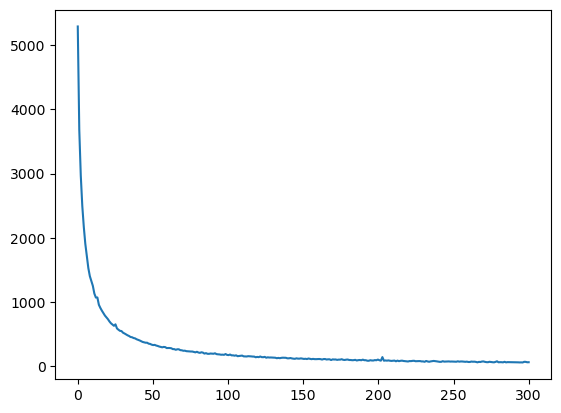

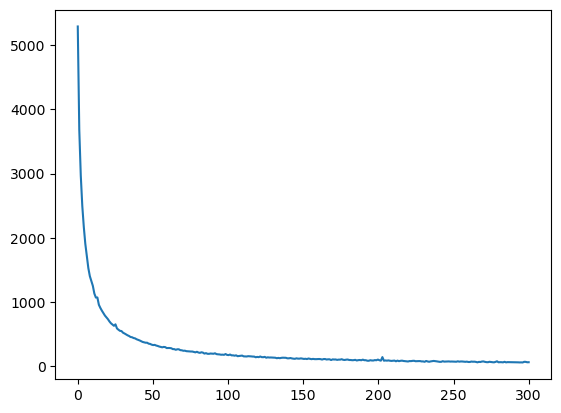

In [60]:
# verifying the convergence of cost
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.show()


In [61]:
torch.save(net.state_dict(), 'model2_weights.pth')

In [92]:
# create confusion matrix

# Initialize the model
load = torch.load("weights/model2_weights.pth")
net = my_net()
net.load_state_dict(load)

# create predcited
output = net(test_X.type(torch.FloatTensor))
_, predicted = torch.max(output.data, 1)

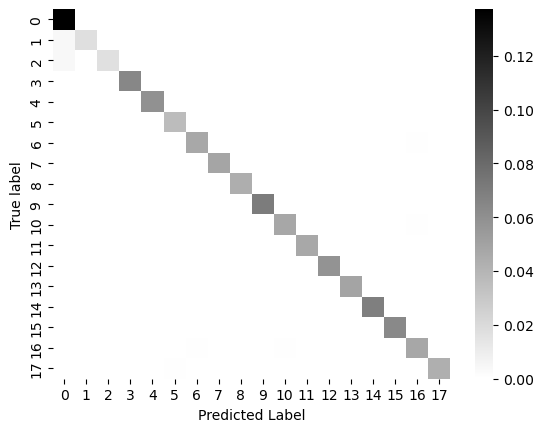

In [106]:
# create confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_y, predicted)
import matplotlib.pyplot as plt
import seaborn as sns
matrix = sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap='binary')
matrix.set(xlabel='Predicted Label', ylabel='True label')
plt.savefig('results/cnn_large_confusion_matrix.png', dpi=3200)
